# Vanilla RNN cell from scratch
## The RNN cell will predict the next value in a sequence given the latest 50 values and a sine wave will be used as input sequence. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)

### It would accept a single sequence of length 50 as input. So the shape of the input data will be:
### `(number_of_records x length_of_sequence x types_of_sequences)`<br>

* ### `number_of_records` the total number of input sequences the network will recieve.
* ### `length_of_sequence` is 50, because this is the number of elements in each input.
* ### `types_of_sequences` is 1, because we have only one type of sequence – the sine wave.

### On the other hand, the output would have only one value for each record. This will of course be the 51st value in the input sequence. So it’s shape would be:
### `(number_of_records x types_of_sequences)` where `types_of_sequences` is 1

In [2]:
seq_len = 50
validation_len = 50

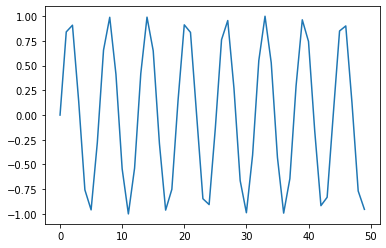

In [3]:
# Sine wave creation with 200 values
sin_wave = np.array([np.sin(x) for x in np.arange(0, 200)])
plt.plot(sin_wave[:seq_len])

In [4]:
X = []
Y = []

sin_wave_len = len(sin_wave)

# Total ammount of values to be predicted (total data lenght - initial sequence values)
num_records = sin_wave_len - seq_len

# Iterates the data to create the trainig values and reserves <validation_len> values for validation
for i in range(num_records - validation_len):
    # Append the 50 values before the current target value
    X.append(sin_wave[i:i+seq_len])
    # Append the current target value
    Y.append(sin_wave[i+seq_len])
    
X = np.array(X)
X = np.expand_dims(X, axis=2)

Y = np.array(Y)
Y = np.expand_dims(Y, axis=1)

print('X shape (<num_records> - <seq_len> - <validation_len>, <seq_len>, <types_of_sequences>): ')
print(X.shape, '\n')

print('Y shape (<num_records> - <seq_len> - <validation_len>, <types_of_sequences>): ')
print(Y.shape)

X shape (<num_records> - <seq_len> - <validation_len>, <seq_len>, <types_of_sequences>): 
(100, 50, 1) 

Y shape (<num_records> - <seq_len> - <validation_len>, <types_of_sequences>): 
(100, 1)


In [5]:
X_val = []
Y_val = []

for i in range(num_records - seq_len, num_records):
    X_val.append(sin_wave[i:i+seq_len])
    Y_val.append(sin_wave[i+seq_len])
    
X_val = np.array(X_val)
X_val = np.expand_dims(X_val, axis=2)

Y_val = np.array(Y_val)
Y_val = np.expand_dims(Y_val, axis=1)

---
---
## **Step 1**: Create the RNN model Architecture

### The model will take in the input sequence, process it through a hidden layer of `<hidden_dim>` units, and produce a single valued output:

### Definig the network weights, where:<br>
* ### **U** is the weight matrix for weights between input and hidden layers
* ### **W** is the weight matrix for shared weights in the RNN layer (hidden layer)
* ### **V** is the weight matrix for weights between hidden and output layers

### Sigmoid activation to be used in the hidden layer:

In [6]:
def sigmoid(x): 
    return 1 / (1 + np.exp(-x))

---
---
## **Step 2**: Train the Model
### The training process can be subdivided into smaller steps, namely: <br>
* ### **Step 2.1:** Check the loss on training data
    - ### **Step 2.1.1:** Forward Pass
    - ### **Step 2.1.2:** Calculate Error <br>
* ### **Step 2.2:** Check the loss on validation data
    - ### **Step 2.2.1:** Forward Pass
    - ### **Step 2.2.2:** Calculate Error <br>
* ### **Step 2.3:** Start actual training
    - ### **Step 2.3.1:** Forward Pass
    - ### **Step 2.3.2:** Backpropagate Error
    - ### **Step 2.3.3:** Update weights

---
## **Step 2.1:** Check the loss on training data
### Make forward pass through our RNN model and calculate the squared error for the predictions for all records in order to get the loss value.
--- 
## **Step 2.2:** Check the loss on validation data - same as training but with validation dataset
---
## **Step 2.3:** Start training
### First do a forward pass to calculate the errors and a backward pass to calculate the gradients and update them. 
## **Step 2.3.1:** Forward Pass:
* ### Multiply the input with the weights between input and hidden layers
* ### Add this with the multiplication of weights in the RNN layer to capture the knowledge of the previous timestep
* ### Pass it through a sigmoid activation function
* ### Multiply this with the weights between hidden and output layers
* ### The output layer have a linear activation of the values so it do not explicitly pass the value through an activation layer
* ### Save the state at the current layer and also the state at the previous timestep in a dictionary}

## **Step 2.3.2:** Backpropagate Error
* ### After the forward propagation step, calculate the gradients at each layer, and backpropagate the errors. It's used truncated back propagation through time (TBPTT), instead of vanilla backprop.
* ### The core difference in BPTT versus backprop is that the backpropagation step is done for all the time steps in the RNN layer. So if the sequence length is 50, it will backpropagate for all the timesteps previous to the current timestep. 
* ### BPTT is very computationally expensive, so instead of backpropagating through all previous timestep , it backpropagate till x timesteps to save computational power. This is ideologically similar to stochastic gradient descent, where it's included a batch of data points instead of all the data points.

## **Step 2.3.3:** Update weights
* ### Update the weights with the gradients of weights calculated. One thing to keep in mind is that the gradients tend to explode.This is a fundamental issue in training neural networks, called the exploding gradient problem. So they have to be clamp in a range so that they dont explode.

In [7]:
class RecurrentCell(object):
    def __init__(self, seq_len, hidden_dim, output_dim):      
        self.hidden_dim = hidden_dim
        
        self.U = np.random.uniform(0, 1, (self.hidden_dim, seq_len))
        self.W = np.random.uniform(0, 1, (self.hidden_dim, self.hidden_dim))
        self.V = np.random.uniform(0, 1, (output_dim, self.hidden_dim))
        
    #-------------------------------------------------------------------------------------------------------   
    def forward(self, x, train=False):
        hid_states = []
        # prev-s is the value of the previous activation of hidden layer; which is initialized as all zeroes
        prev_s = np.zeros((self.hidden_dim, 1))
        # forward each input element in the current input sequence - each input element is considered a timestep
        for t in range(len(x)):
            # do a forward pass for every timestep in the sequence
            new_input = np.zeros(x.shape)
            #define a single input for that timestep
            new_input[t] = x[t]
            # multiply the input sequence by the input weights
            mulu = np.dot(self.U, new_input)
            # multiply the previous state by the recurrent weights
            mulw = np.dot(self.W, prev_s)
            # generate the new hidden state array
            add = mulw + mulu
            s = sigmoid(add)
            # multiply the new hidden state by the hid-out weights to generate the output
            mulv = np.dot(self.V, s)
            # add the current and previous sates arrays to the array if in train
            if(train): hid_states.append({'s':s, 'prev_s':prev_s})
            # assing the current hidden state as the last hidden state
            prev_s = s
            
        return (mulu, mulw, add, mulv), hid_states
    
    #-------------------------------------------------------------------------------------------------------
    def get_batch_loss(self, X, Y):
        loss = 0.0
        # forward each input sequence to get a prediction for that input
        for i in range(len(Y)):
            # get input, output values of each record
            x, y = X[i], Y[i]
            # feed-forward the current input
            (mulu, mulw, add, y_pred), _ = self.forward(x)
            # calculate error for that given output
            loss_per_record = (y - y_pred)**2 / 2
            # add to the batch loss
            loss += loss_per_record
        # Gets the MAE
        loss = loss / float(Y.shape[0])
        return loss
    
    #-------------------------------------------------------------------------------------------------------
    def predict(self, X):
        preds = []
        prev_s = np.zeros((self.hidden_dim, 1))
        for x in X:
            # multiply the input sequence by the input weights
            mulu = np.dot(self.U, x)
            # multiply the previous state by the recurrent weights
            mulw = np.dot(self.W, prev_s)
            # generate the new hidden state array
            add = mulw + mulu
            s = sigmoid(add)
            # multiply the new hidden state by the hid-out weights to generate the output
            mulv = np.dot(self.V, s)
            preds.append(mulv)
            # assing the current hidden state as the last hidden state
            prev_s = s

        preds = np.array(preds)
        return preds
    
    #-------------------------------------------------------------------------------------------------------
    def train(self, X_train, Y_train, X_val, Y_val, lr=0.0001, epochs=25, bptt_truncate=5, min_clip_value=-10, max_clip_value=10):
        # train in the given number of epochs
        for epoch in range(epochs):
            
            loss = self.get_batch_loss(X_train, Y_train)
            val_loss = self.get_batch_loss(X_val, Y_val)
            print('Epoch: ', epoch + 1, ', Loss: ', loss, ', Val Loss: ', val_loss)
            
            # train for each input sequence
            for i in range(len(Y_train)):
                x, y = X_train[i], Y_train[i]
                # creates the weights gradients
                dU = np.zeros(self.U.shape)
                dV = np.zeros(self.V.shape)
                dW = np.zeros(self.W.shape)
                # gradients for the timestep
                dU_t = np.zeros(self.U.shape)
                dV_t = np.zeros(self.V.shape)
                dW_t = np.zeros(self.W.shape)
                # gradients for BPTT past steps
                dU_i = np.zeros(self.U.shape)
                dW_i = np.zeros(self.W.shape)
                
                # forward the current input to generate the output
                (mulu, mulw, add, mulv), hid_states = self.forward(x, train=True)
 
                # prediction error
                dmulv = (mulv - y)

                for t in range(len(x)):
                    # get the hid-out weights gradient related to the current hidden state array
                    dV_t = np.dot(dmulv, np.transpose(hid_states[t]['s']))
                    # back propagate the error to the output weights inputs (current state)
                    dsv = np.dot(np.transpose(self.V), dmulv)
                    # back propagate the  error to the pre-activation current state
                    dadd = add * (1 - add) * dsv
                    # back propagate the error to the recurrent layer output
                    dmulw = dadd * np.ones_like(mulw)
                    # back propagate the error to the recurrent layer input (previous state)
                    dprev_s = np.dot(np.transpose(self.W), dmulw)
                    
                    # iterate through the last timesteps defined for the BPTT
                    for i in range(t-1, max(-1, t-bptt_truncate-1), -1):
                        # back propagates the error to the current state
                        ds = dsv + dprev_s
                        # back propagates the error to the pre-activation current state
                        dadd = add * (1 - add) * ds
                        # back propagate the pre-activation hidden state error to the hidden and input weights
                        dmulw = dadd * np.ones_like(mulw)
                        dmulu = dadd * np.ones_like(mulu)
                        # get the gradient of the hidden weights reated to the provuious hidden state
                        dW_i = np.dot(self.W, hid_states[i]['prev_s'])
                        # back propagates the error to the recurrent layer input (previous state) 
                        dprev_s = np.dot(np.transpose(self.W), dmulw)
                        # get the input weights derivative
                        new_input = np.zeros(x.shape)
                        new_input[i] = x[i]
                        dU_i = np.dot(self.U, new_input)
                        # back propagate the error to the current input
                        dx = np.dot(np.transpose(self.U), dmulu)
                        # sum the BPTT gradients to the timestep gradients
                        dU_t += dU_i
                        dW_t += dW_i
                        
                    # sum the BPTT derivatives to the timestep derivatives 
                    dV += dV_t
                    dU += dU_t
                    dW += dW_t
                    
                    # clip the derivatives to avoid gradient explosion
                    if dU.max() > max_clip_value: dU[dU > max_clip_value] = max_clip_value
                    if dV.max() > max_clip_value: dV[dV > max_clip_value] = max_clip_value
                    if dW.max() > max_clip_value: dW[dW > max_clip_value] = max_clip_value

                    if dU.min() < min_clip_value: dU[dU < min_clip_value] = min_clip_value
                    if dV.min() < min_clip_value: dV[dV < min_clip_value] = min_clip_value
                    if dW.min() < min_clip_value: dW[dW < min_clip_value] = min_clip_value

                
                # update the weights
                self.U -= lr * dU
                self.V -= lr * dV
                self.W -= lr * dW
            
        loss = self.get_batch_loss(X_train, Y_train)
        val_loss = self.get_batch_loss(X_val, Y_val)
        print('FINISHED - Loss: ', loss, ', Val Loss: ', val_loss)

In [8]:
#%%script false --no-raise-error
recCell = RecurrentCell(seq_len=len(X[0]), hidden_dim=100, output_dim=len(Y[0]))
recCell.train(X, Y, X_val, Y_val, lr=0.00007, epochs=15, bptt_truncate=5, min_clip_value=-10, max_clip_value=10)

Epoch:  1 , Loss:  [[1011.85617567]] , Val Loss:  [[1011.8206803]]
Epoch:  2 , Loss:  [[721.49513357]] , Val Loss:  [[721.46503904]]
Epoch:  3 , Loss:  [[480.13409148]] , Val Loss:  [[480.10939778]]
Epoch:  4 , Loss:  [[287.77304939]] , Val Loss:  [[287.75375653]]
Epoch:  5 , Loss:  [[144.41200647]] , Val Loss:  [[144.39811445]]
Epoch:  6 , Loss:  [[50.05070375]] , Val Loss:  [[50.04221222]]
Epoch:  7 , Loss:  [[4.69229297]] , Val Loss:  [[4.68917511]]
Epoch:  8 , Loss:  [[0.21443043]] , Val Loss:  [[0.21379309]]
Epoch:  9 , Loss:  [[0.17170854]] , Val Loss:  [[0.17137925]]
Epoch:  10 , Loss:  [[0.17140597]] , Val Loss:  [[0.17113516]]
Epoch:  11 , Loss:  [[0.17430489]] , Val Loss:  [[0.17394641]]
Epoch:  12 , Loss:  [[0.17450079]] , Val Loss:  [[0.17413167]]
Epoch:  13 , Loss:  [[0.17129632]] , Val Loss:  [[0.17096117]]
Epoch:  14 , Loss:  [[0.17377639]] , Val Loss:  [[0.17345363]]
Epoch:  15 , Loss:  [[0.17202441]] , Val Loss:  [[0.17169189]]
FINISHED - Loss:  [[0.1730824]] , Val Los

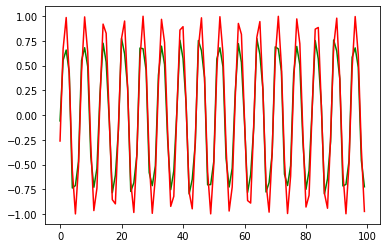

In [9]:
preds = recCell.predict(X)
plt.plot(preds[:, 0, 0], 'g')
plt.plot(Y[:, 0], 'r')
plt.show()

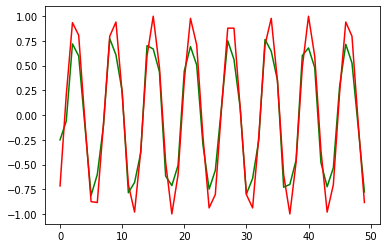

In [10]:
preds = recCell.predict(X_val)
plt.plot(preds[:, 0, 0], 'g')
plt.plot(Y_val[:, 0], 'r')
plt.show()